In [ ]:
colab = True
train_model = False
load_weights = True
make_labels = False
remote = False

num = 9 # dataset version number for files on local machine
batch_size = 2
num_epochs = 6

Cloning into 'insall-salvati-ratio'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 146 (delta 67), reused 102 (delta 23), pack-reused 0
Receiving objects: 100% (146/146), 20.18 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Mounted at /content/drive


In [ ]:
import os
import json, cv2, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datetime
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.models.detection import KeypointRCNN
import albumentations as A
import pandas as pd
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML
from torchsummary import summary
import math
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
from openpyxl.utils import get_column_letter
import glob
from natsort import natsorted
import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
#from torchvision.models.feature_extraction import create_feature_extractor

def get_model(num_keypoints, weights_path=None):

    backbone = torchvision.models.convnext_large(weights='DEFAULT').features
    backbone.out_channels = 1536 # 1536 for convnext_large

    anchor_generator = AnchorGenerator(sizes=((64, 128, 256),), aspect_ratios=((0.83, 1.7, 1.2),)) # these need to be tweaked for the very large dataset

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                             output_size=14,
                                                             sampling_ratio=2)

    model = KeypointRCNN(backbone,
                          num_classes=2,
                          rpn_anchor_generator=anchor_generator,
                          box_roi_pool=roi_pooler,
                          keypoint_roi_pool=keypoint_roi_pooler,
                          num_keypoints=num_keypoints)

    if weights_path:
        print("loading weights from: ", weights_path)
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

In [ ]:
%%capture
# suppress output, contains summary of the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if colab == True:
    save_path = r"/content/drive/MyDrive/PatellaData/keypointsrcnn_weights_convnext_large_v9_dataset.pth"
 elif remote == True:
    save_path = r"/mnt/f/patella/yolov7/data/r-cnn_weights/keypointsrcnn_weights_convnext_large_v9_dataset.pth"
else:
    save_path = r"F:\patella\yolov7\data\r-cnn_weights\keypointsrcnn_weights_convnext_large_v9_dataset.pth"

if load_weights == True:
    model = get_model(num_keypoints = 3, weights_path=save_path) # load saved weights
    print("Loaded weights from: ", save_path)
else:
    model = get_model(num_keypoints = 3)

model.to(device)

In [ ]:
def calc_distance(kp1, kp2):
    x1, y1 = kp1
    x2, y2 = kp2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calc_mean_distance_error(real_keypoints, pred_keypoints):
    mean_distance = 0
    point_error = [0,0,0]
    assert len(real_keypoints) == len(pred_keypoints)
    for i in range(len(real_keypoints)):
        for j in range(len(real_keypoints[i])):
            point_error[j] = calc_distance(real_keypoints[i][j], pred_keypoints[i][j])
            mean_distance += point_error[j]
    return mean_distance/len(keypoints), point_error

def calc_insall_salvati_ratio(top_keypoint, middle_keypoint, bottom_keypoint):
    return calc_distance(top_keypoint, middle_keypoint) / calc_distance(middle_keypoint, bottom_keypoint) if calc_distance(middle_keypoint, bottom_keypoint) else 0 #prevent division by zero

def classify_insall_salvati(ratio):
    if ratio > 1.2:
        return "Patella Alta"
    elif ratio < 0.8:
        return "Patella Baja"
    else:
        return "Patella Normal"

# return the best set of keypoints
def get_best_keypoints_old(scores):
    if len(scores) is 0: return None
    avg_scores = []
    for score in scores:
        avg_scores.append(torch.mean(score))
    return avg_scores.index(max(avg_scores))

# return the best keypoint across all guesses
def get_best_keypoints(points, losses):
  if len(losses) is 0: return None
  max_indices = np.argmax(losses, axis=0)
  return_arr = []
  for x in range(3):
    return_arr.append(points[max_indices[x]][x])
  return return_arr

<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-a6f3ec6e165f>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(scores) is 0: return None
<ipython-input-6-a6f3ec6e165f>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(losses) is 0: return None


In [ ]:
from pathlib import Path

def process_and_predict(image_file, LINE=True, COLOR=(255,255,0), DOTSIZE=3, LINESIZE=1, CONFIDENCE=0.5):
    my_file = Path(image_file)
    if not my_file.is_file(): return None, None, 0.0
    raw_img = cv2.imread(image_file)
    aspect_ratio = raw_img.shape[0]/raw_img.shape[1]

    raw_img = cv2.resize(raw_img, (456, 456))
    test_img = np.moveaxis(raw_img, -1, 0)
    test_img= np.expand_dims(test_img, axis=0)
    test_img = torch.from_numpy(test_img).float().to(device)

    ISR = 0.0

    if aspect_ratio < 3.5 and aspect_ratio > 0.3:
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(test_img)

        if len(output) == 0: return None, None, 0.0
        if 'scores' not in output[0]: return None, None, 0.0
        if len(output[0]['scores']) == 0: return None, None, 0.0

        # for predictions, if low bbox confidence, return none
        score = float(output[0]['scores'][0].detach().cpu().numpy())
        if score < CONFIDENCE: return output, raw_img, ISR

        # if no keypoints detected, return none

        losses = output[0]['keypoints_scores'].detach().cpu().numpy()
        points = output[0]['keypoints'].detach().cpu().numpy()
        keypoints = get_best_keypoints(points, losses)

        if keypoints is None: return output, raw_img, ISR

        for idx, kp in enumerate(keypoints):
            current_keypoint = kp[:2].astype(int)
            raw_img = cv2.circle(raw_img, current_keypoint, DOTSIZE, COLOR, DOTSIZE)

        # draw lines
        if LINE is True:
          raw_img = cv2.line(raw_img, (int(keypoints[0][0]),int(keypoints[0][1])), (int(keypoints[1][0]),int(keypoints[1][1])), COLOR, LINESIZE)
          raw_img = cv2.line(raw_img, (int(keypoints[2][0]),int(keypoints[2][1])), (int(keypoints[1][0]),int(keypoints[1][1])), COLOR, LINESIZE)
        plt.figure(figsize=(10,10))
        plt.imshow(raw_img)

        # multiply y coordinates by aspect_ratio to calc actual distance
        keypoints[0][1] *= aspect_ratio
        keypoints[1][1] *= aspect_ratio
        keypoints[2][1] *= aspect_ratio

        print(keypoints)

        ISR = calc_insall_salvati_ratio((int(keypoints[0][0]),int(keypoints[0][1])), (int(keypoints[1][0]),int(keypoints[1][1])), (int(keypoints[2][0]),int(keypoints[2][1])))
        ISR = round(ISR, 3)
        return output, raw_img, ISR
    else:
        return None, raw_img, ISR

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
keypoints_classes_ids2names = {0: 'Bottom', 1: 'Middle', 2: 'Top'}

In [ ]:
from pathlib import Path

def run_predict(image_file, CONFIDENCE = 0.4):
    my_file = Path(image_file)
    if not my_file.is_file(): return None, None, 0.0
    raw_img = cv2.imread(image_file)
    aspect_ratio = raw_img.shape[0]/raw_img.shape[1]

    raw_img = cv2.resize(raw_img, (456, 456))
    test_img = np.moveaxis(raw_img, -1, 0)
    test_img= np.expand_dims(test_img, axis=0)
    test_img = torch.from_numpy(test_img).float().to(device)

    ISR = 0.0

    if aspect_ratio < 3.5 and aspect_ratio > 0.3:
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(test_img)

        if len(output) == 0: return None, None, 0.0
        if 'scores' not in output[0]: return None, None, 0.0
        if len(output[0]['scores']) == 0: return None, None, 0.0

        # for predictions, if low bbox confidence, return none
        score = float(output[0]['scores'][0].detach().cpu().numpy())
        if score < CONFIDENCE: return output, raw_img, ISR

        # if no keypoints detected, return none

        losses = output[0]['keypoints_scores'].detach().cpu().numpy()
        points = output[0]['keypoints'].detach().cpu().numpy()
        keypoints = get_best_keypoints(points, losses)

        if keypoints is None: return output, raw_img, ISR

        for idx, kp in enumerate(keypoints):
            current_keypoint = kp[:2].astype(int)
            raw_img = cv2.circle(raw_img, current_keypoint, 1, (255,255,0), 3)

        # draw lines
        raw_img = cv2.line(raw_img, (int(keypoints[0][0]),int(keypoints[0][1])), (int(keypoints[1][0]),int(keypoints[1][1])), (255,255,0), 1)
        raw_img = cv2.line(raw_img, (int(keypoints[2][0]),int(keypoints[2][1])), (int(keypoints[1][0]),int(keypoints[1][1])), (255,255,0), 1)
        #image_original = cv2.putText(raw_img, " " + keypoints_classes_ids2names[idx], current_keypoint, cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2, cv2.LINE_AA)

        # multiply y coordinates by aspect_ratio to calc actual distance
        keypoints[0][1] *= aspect_ratio
        keypoints[1][1] *= aspect_ratio
        keypoints[2][1] *= aspect_ratio

        ISR = calc_insall_salvati_ratio((int(keypoints[0][0]),int(keypoints[0][1])), (int(keypoints[1][0]),int(keypoints[1][1])), (int(keypoints[2][0]),int(keypoints[2][1])))
        ISR = round(ISR, 3)
        return output, raw_img, ISR
    else:
        return None, raw_img, ISR

[array([183.67804, 465.36575,   1.     ], dtype=float32), array([104.878914, 300.90875 ,   1.      ], dtype=float32), array([111.326836, 171.08055 ,   1.      ], dtype=float32)]
1.416


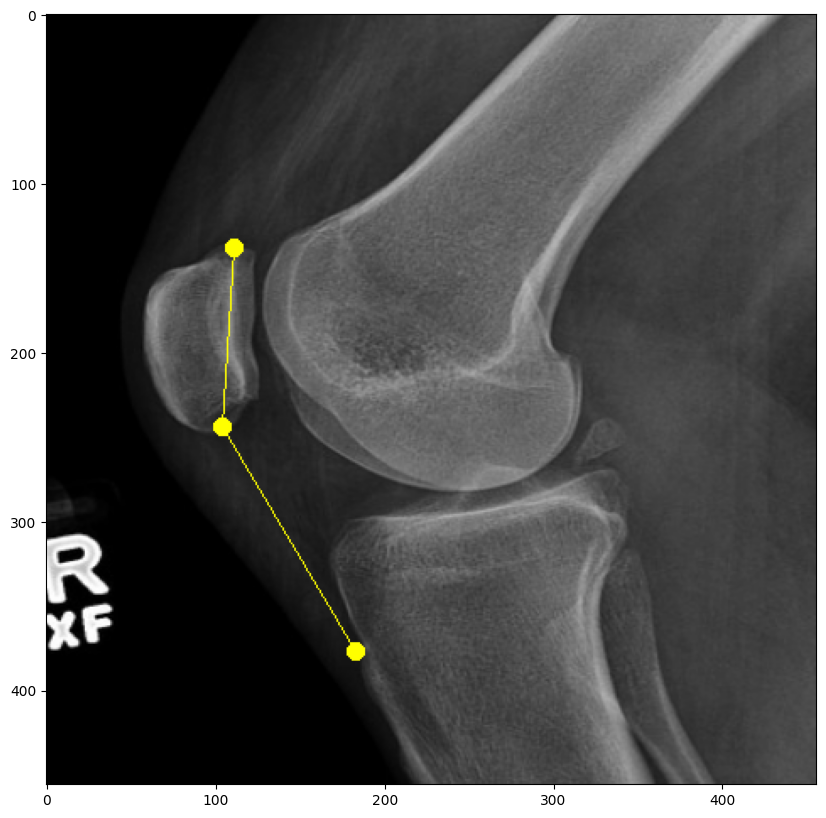

In [ ]:
f = "/content/6.jpeg"
output, img, ISR = process_and_predict(f, CONFIDENCE=0.2)
print(ISR)

In [ ]:
def mean(data):
    """Return the sample arithmetic mean of data."""
    n = len(data)
    if n < 1:
        raise ValueError('mean requires at least one data point')
    return sum(data)/n # in Python 2 use sum(data)/float(n)

def _ss(data):
    """Return sum of square deviations of sequence data."""
    c = mean(data)
    ss = sum((x-c)**2 for x in data)
    return ss

def stddev(data, ddof=0):
    """Calculates the population standard deviation
    by default; specify ddof=1 to compute the sample
    standard deviation."""
    n = len(data)
    if n < 2:
        raise ValueError('variance requires at least two data points')
    ss = _ss(data)
    pvar = ss/(n-ddof)
    return pvar**0.5

len(d['ISR'])

In [ ]:
def sum_cols(cma): return np.sum(cma, axis=0)
def sum_rows(cma): return np.sum(cma, axis=1)
def sum_diag(cma): return sum([cma[i][i] for i,_ in enumerate(cma)])
def sum_square(cma, x):
  x0 = max(0, x-1)
  x1 = min(len(cma)-1, x+1)
  if x == 0: return cma[x][x]+cma[x][x1]
  elif x == len(cma)-1: return cma[x][x]+cma[x][x0]
  else: return cma[x][x]+cma[x][x0]+cma[x][x1]
def get_fp(cma, x, tp):
  return sum_cols(cma)[x]-tp
def get_fn(cma, x, tp):
  return sum_rows(cma)[x]-cma[x][x]

print("specific decile")

acc1 = 0
for x in range(len(cma)):
  tot = sum(sum(cma))
  tp = cma[x][x]
  fp = sum_cols(cma)[x]-tp
  fn = sum_rows(cma)[x]-tp
  tn = tot-tp-fp-fn
  acc = float((tp+tn)/(tot))
  spec = float(tn/(tn+fp))
  sens = float(tp/(tp+fn))
  acc1 += acc/len(cma)
  print(label_names[x])
  print("acc "+str(round(acc, 3))+": spec "+str(round(spec, 3))+": sens "+str(round(sens, 3))+": m_acc "+str(round(acc1, 3)))
print()